# Avazu CTR Custom Classifier



In [1]:
import random
import pandas as pd
import numpy as np
from sklearn.metrics import *

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier


from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt


In [2]:
''' Sample from Training Data down to 1 million records'''

n = 40428966  #total number of records in the dataset 
sample_size = 1000000
skiprows = sorted(random.sample(range(1,n-1), n-sample_size)) 

#Tracking the indices of rows to be skipped at random

In [3]:
#import the dataframe with skipped rows, since it is in gz we must add a parameter for compression
ctr_data = pd.read_csv('https://bidtime.s3.amazonaws.com/Avazu/train/train.gz', skiprows=skiprows, compression='infer')

In [4]:
#Click through rate is an inbalanced class problem, because the majority of impressions do not lead to a conversion
#We can verify this by looking at the value counts. We see that this dataset has about 17% clicks
#In the real world, that would be an amazing CTR, so we can assume this data has been upsampled
ctr_data.click.value_counts()

0    829946
1    170055
Name: click, dtype: int64

In [5]:
# by default majority class (No Click-0) will be negative
lb = LabelBinarizer()
ctr_data['click'] = lb.fit_transform(ctr_data['click'].values)
targets = ctr_data['click']


In [6]:
#We can also drop a few features that will not improve the model
ctr_data.drop(['click', 'id', 'device_id', 'device_ip'], axis=1, inplace=True)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ctr_data, targets, test_size=0.1, random_state=42, shuffle=False)

In [8]:
enc = OneHotEncoder(handle_unknown='ignore')
X_train = enc.fit_transform(X_train)
X_test = enc.transform(X_test)

In [9]:
clf = SGDClassifier(loss='log', penalty=None, fit_intercept=True, max_iter=10, learning_rate='constant', eta0=0.01)


param_grid = {
 'eta0': [0.165, 0.17, 0.175, .18]   
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [10]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    This function fits a GridSearchCV classifier using refit_score for 
    optimization and prints the classifier's confusion matrix
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['predicted_no_click', 'preditced_click'], index=['No click', 'Click']))
    return grid_search

In [11]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'eta0': 0.165}

Confusion matrix of Random Forest optimized for precision_score on the test data:
          predicted_no_click  preditced_click
No click               73532             9673
Click                  11637             5159


In [12]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_eta0'
         ]].head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_eta0
0,0.242138,0.255821,0.694063,0.165
2,0.241975,0.205430,0.713131,0.175
3,0.235003,0.241722,0.704880,0.18
1,0.223830,0.197796,0.715857,0.17


In [13]:
#Earlier we had our best eta0 at .165, but when we optimize for recall score
#the best eta0 is .17. 
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Best params for recall_score
{'eta0': 0.17}

Confusion matrix of Random Forest optimized for recall_score on the test data:
          predicted_no_click  preditced_click
No click               76012             7193
Click                  13544             3252


In [14]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score',
        ]].head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score
1,0.219989,0.290039,0.682690
3,0.198636,0.225422,0.699949
0,0.217006,0.206879,0.713864
2,0.216372,0.204333,0.708243


In [15]:
y_scores = grid_search_clf.predict_proba(X_test)[:, 1]


In [16]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    """
    return [1 if y >= t else 0 for y in y_scores]

In [17]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)


In [18]:
def precision_recall_threshold(t=0.5):
    """
    This function plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['predicted_no_click', 'preditced_click'],
                       index=['No click', 'Click']))

## Precision Recall Threshold

The lower the Precision Recall Threshold, the more clicks our model will capture. However, a low PRT will also result in more no-clicks being pedicted as clicks. I chose a PRT of .2, which is aggressive enough to capture 66% of the clicks, but predicts a click incorrectly only 41% of the time. The more aggressive our bidding strategy, the more clicks we can confidently capture. This model would work best for high value items, such as luxury goods. The cost of impressions for these items is high, but the revenue we can generate by capturing conversions is also high. That will offset the money spent on impressions that do not lead to conversions.

Below you can see how the confusion matrix changes depending on the PRT.

In [19]:
precision_recall_threshold(0.001)

          predicted_no_click  preditced_click
No click                1497            81708
Click                     32            16764


In [20]:
precision_recall_threshold(0.1)

          predicted_no_click  preditced_click
No click               42547            40658
Click                   4125            12671


In [21]:
precision_recall_threshold(0.2)

          predicted_no_click  preditced_click
No click               55386            27819
Click                   7115             9681


In [22]:
precision_recall_threshold(0.3)

          predicted_no_click  preditced_click
No click               64878            18327
Click                  10008             6788


In [23]:
precision_recall_threshold(0.4)

          predicted_no_click  preditced_click
No click               71275            11930
Click                  12005             4791


In [24]:
precision_recall_threshold(.990)

          predicted_no_click  preditced_click
No click               83204                1
Click                  16788                8


In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    This function will allow us to plot the precision vs the recall as a result of the PRT.
    As you can see they converge around .2, the number we chose for our bidding strategy.
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

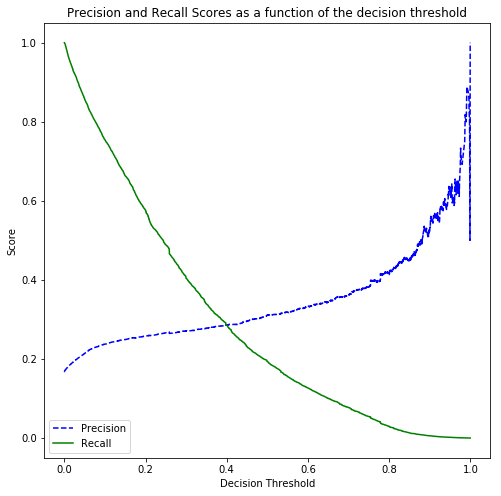

In [26]:
plot_precision_recall_vs_threshold(p, r, thresholds)


In [27]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    This function allows us to plot the ROC Curve
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

Average ROC: 0.6702583084165381


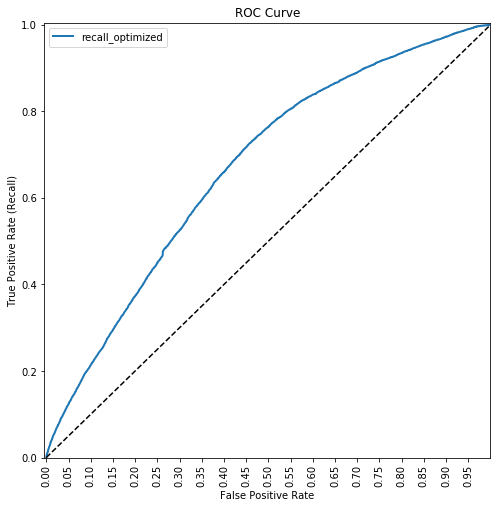

In [29]:
#With an optimized recall we can expect to our average ROC to be about .67
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print('Average ROC:',auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')